In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
from utils.preprocess import load_ninapro_data, preprocess_emg
dataPath = parentDir / "data" / "raw" / "ninapro-db2"

In [2]:
subject_number = 1
exercise_number = 1
channel_to_plot = 1

In [3]:
emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)

In [4]:
filtered_emg = preprocess_emg(emg[:, channel_to_plot], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

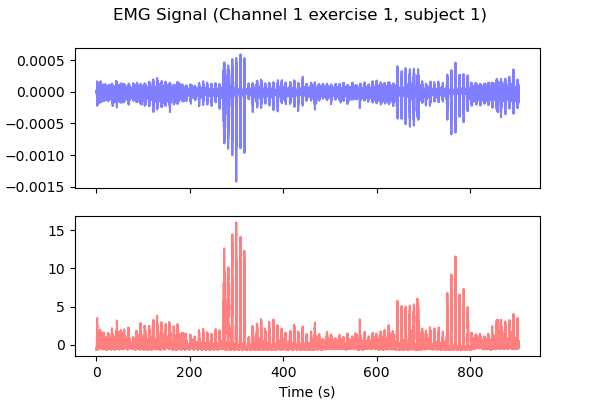

In [6]:
 # Plot raw and filtered EMG signals for comparison

fig, axs = plt.subplots(2,1, figsize=(6, 4), sharex=True)
axs[0].plot(time, emg[:, channel_to_plot], color='blue', label='Raw EMG', alpha=0.5)
axs[1].plot(time, filtered_emg, color='red', label='Filtered EMG', alpha=0.5)
plt.suptitle(f'EMG Signal (Channel {channel_to_plot} exercise {exercise_number}, subject {subject_number})')
plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.tight_layout()
plt.show()